<a href="https://colab.research.google.com/github/CarlosEduardo254/Trabalho_Final_Grafos/blob/main/Trabalho_Final_de_Grafos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import networkx as nx

In [2]:
# Leitura do arquivo txt e conversão da matriz de adjacências
def ler_matriz_do_arquivo(nome_arquivo):
    matriz_adj = []
    with open(nome_arquivo, 'r') as f: # Abre o arquivo em modo leitura
        for linha in f:
            if not linha.strip(): continue #Ignora linhas em branco
            numeros_str = linha.strip()[1:-1] # Vai fazer a mesma coisa da linha de cima, mas com a diferença que o [1:-1] remove os colchetes '[' e ']' deixando só uma lista de números
            lista_de_numeros_str = numeros_str.split(',')  # Obtenção dos números diovidindo a string pela vírgula
            linha_float = [float(n) for n in lista_de_numeros_str] # COnversão de string para float
            matriz_adj.append(linha_float) #
    return matriz_adj, len(matriz_adj)

In [3]:
import heapq

def calcular_arvoregm(matriz_adj, num_vertices):
    # Usaremos o algoritmo de Prim com uma fila de prioridade (min-heap) para otimização
    agm = {i: [] for i in range(num_vertices)}

    # O Parente serve para armazenar o pai de cada vértice na árvore geradora mínima
    parente = [None] * num_vertices

    # O Custo_para_conectar serve para armazenar o custo mínimo para ligar o vértice atual a árvore geradora mínima
    # E também, antes de adicionarmos uma nova aresta ao heap, checamos aqui se ela é realente
    # melhor que a melhor opção que já temos para aquele vértice, evitando colocar caminhos piores no nosso heap
    custo_para_conectar = [float('inf')] * num_vertices

    # O Incluidos_agm serve para marcar os vértices já incluídos na árvore, impedir que ciclos aconteçam, pois não olhamos para vizinhos já incluidos
    # E Também filtra entradas que já não nos servem mais que saem do heap
    incluidos_agm = [False] * num_vertices

    # Agora criamos uma fila de prioridade, ela vai armazenar tuplas no formato (custo, vertice) pro nosso heap ordenar pelo custo
    pq = []

    # Vamos começar pelo vértice 0
    custo_para_conectar[0] = 0
    # Como o vertice inicial não tem pai, vamos atribuir a ele o valor -1 (-1 em vez de 0 para deixar claro que o vertice 0 nunca vai ter um pai e também remove a ambiguidade de 0 ser pai de 0)
    parente[0] = -1
    # Adicionamos nosso ponto de partida ao heap, sendo (custo, vértice)
    heapq.heappush(pq, (0, 0))

    # O loop vai continuar executando enquanto houver itens na fila de prioridade.
    while pq:
        # Retiramos o vértice com o menor custo de conexão
        # No caso, encontramos e removemos o item de menor valor da fila pq e retornamos esse item que foi removido.
        custo, u = heapq.heappop(pq)

        # Se o vertice u já foi incluído, então temos que o que retiramos do heap foi uma entrada que não tem mais valor pra gente, então ignoramos e passamos pro próximo
        if incluidos_agm[u]:
            continue

        # Se ele não foi incluído, então agora vamos incluir oficialmente na nossa árvore geradora minima
        incluidos_agm[u] = True

        # Atualizamos o custo mínimo de conexão dos vizinhos de u
        for v in range(num_vertices):
            peso_aresta = matriz_adj[u][v]

            # Se encontramos um caminho mais barato para um vértice v que ainda não está na nossa árvore geradora mínima
            # atualizamos as informações de custo e pai e adicionamos essa opção mais barata no nosso heap
            if not incluidos_agm[v] and peso_aresta > 0 and peso_aresta < custo_para_conectar[v]:
                custo_para_conectar[v] = peso_aresta
                parente[v] = u
                heapq.heappush(pq, (peso_aresta, v))

    # Construimos a lista de adjacências da árvore geradora mínima a partir de parente
    for i in range(1, num_vertices):
        pai = parente[i]
        # Como o grafo é conexo, todo vértice vai ter um pai, menos a raiz.
        if pai != -1:
            filho = i
            agm[pai].append(filho)
            agm[filho].append(pai)

    # --- Construção da Saída Formatada ---

    # 1. Cria a lista de arestas no formato (u, v, {'weight': w})
    arestas_formatadas = []
    for filho in range(1, num_vertices):
        pai = parente[filho]
        if pai is not None and pai != -1:
              peso = matriz_adj[pai][filho]
              arestas_formatadas.append((pai, filho, {'weight': peso}))

    # 2. Calcula o peso total
    peso_total = sum(custo for custo in custo_para_conectar if custo != float('inf'))

    # 3. Retorna a lista de arestas e o peso total
    return arestas_formatadas, peso_total

In [4]:
def encontrar_vertices_grau_impar(arestas_agm, num_vertices):
    grau = {i: 0 for i in range(num_vertices)} # Criamos um dicionário onde cada vértice começa com um grau 0
    for u, v, _ in arestas_agm: # O código percorre cada aresta da AGM
        grau[u] += 1 # Como a aresta conecta o vértice u, aumentamos a contagem de grau dele em 1.
        grau[v] += 1 # A aresta também conecta o vértice v, então também aumentamos a contagem de grau dele em 1.

    vertices_impares = [v for v, d in grau.items() if d % 2 != 0] # Pegamos os vértice impares contidos em grau
    return vertices_impares

In [5]:
def encontrar_emparelhamento_minimo(matriz_adj, vertices_impares):
  subgrafo = nx.Graph()
  # Nesses dois loops vamos garantir que não exista pares de vértices repetidos (1, 1)
  # e não criamos pares duplicados (1, 2) e (2, 1)
  for i in range(len(vertices_impares)):
    for j in range(i + 1, len(vertices_impares)):
      u = vertices_impares[i]
      v = vertices_impares[j]
      peso = matriz_adj[u][v]
      if peso > 0: # aqui evitamos loops de vértices e evitamos erros/bugs com arestas nulas
        subgrafo.add_edge(u, v, weight=peso)
  # Passamos o Grafo, no weight falamos para a função considerar o custo de cada aresta, para assim obtermos o custo mínimo
  emparelhamento_minimo = nx.min_weight_matching(subgrafo, weight='weight')

  # Formatação da saída para uma lista de arestas seguindo o padrão da AGM
  arestas_emparelhamento = []
  peso_total = 0
  for u, v in emparelhamento_minimo:
    peso = matriz_adj[u][v]
    arestas_emparelhamento.append((u, v, {'weight': peso}))
    peso_total += peso

  return arestas_emparelhamento, peso_total


In [6]:
def encontrar_ciclo_euleriano(multigrafo_arestas, num_vertices):
    # Implementação do Algoritmo de Hierholzer
    #Criando uma lista de adjacências para o multigrafo H
    adjacencias_H = {i: [] for i in range(num_vertices)}
    # O Peso é irrelevante para o algoritmo de Hierholzer, por isso o _
    for u, v, _ in multigrafo_arestas:
        adjacencias_H[u].append(v)
        adjacencias_H[v].append(u)

    # Escolhendo um ponto de partida e inicializando as estruturas
    vertice_inicial = multigrafo_arestas[0][0]
    pilha = [vertice_inicial]
    circuito = []

    # Inicio do loop principal do Hierholzer
    while pilha:
        # Em Python, -1 acessa o último elemento de uma lista. Em uma pilha, o último
        # elemento é considerado o topo.
        vertice_atual = pilha[-1]

        # Se ainda há arestas para explorar a partir do vértice atual
        if adjacencias_H[vertice_atual]:
            vizinho = adjacencias_H[vertice_atual].pop() # Pega um vizinho
            # Remove a aresta de mão dupla
            adjacencias_H[vizinho].remove(vertice_atual)
            pilha.append(vizinho) # Continua o passeio
        else:
            # Só executa quando o explorador está em `vertice_atual` e a lista de vizinhos
            # está vazia. Significando que não há mais para onde ir a partir daqui.
            # Retira esse vértice e o adiciona à lista do circuito final.
            # Essencialmente, estamos registrando a rota final na ordem inversa em que a descobrimos.
            # Adicionamos um vértice ao nosso mapa final somente APÓS termos explorado tudo a partir dele.
            circuito.append(pilha.pop())

    # O circuito é construído ao contrário, por conta da foirma como o algoritmo é construído
    # A notação [::-1] serve para inverter a lista inteira
    return circuito[::-1]

In [7]:
def fazer_atalho_e_calcular_custo(ciclo_euleriano, matriz_adj):
    # Percorre o ciclo euleriano, cria atalhos pulando vértices já visitados
    # e calcula o custo total do ciclo hamiltoniano resultante.

    caminho_hamiltoniano = []
    visitados = set()

    # Criando o caminho hamiltoniano pulando vértices repetidos
    for vertice in ciclo_euleriano:
        if vertice not in visitados:
            caminho_hamiltoniano.append(vertice)
            visitados.add(vertice)

    # Adicionando o primeiro vértice ao final, fechando assim o ciclo
    caminho_hamiltoniano.append(caminho_hamiltoniano[0])

    # Calculando o custo total
    custo_total = 0
    for i in range(len(caminho_hamiltoniano) - 1):
        u = caminho_hamiltoniano[i]
        v = caminho_hamiltoniano[i+1]
        custo_total += matriz_adj[u][v]

    return caminho_hamiltoniano, custo_total

Gerando layout do grafo...
Mostrando o grafo completo inicial...


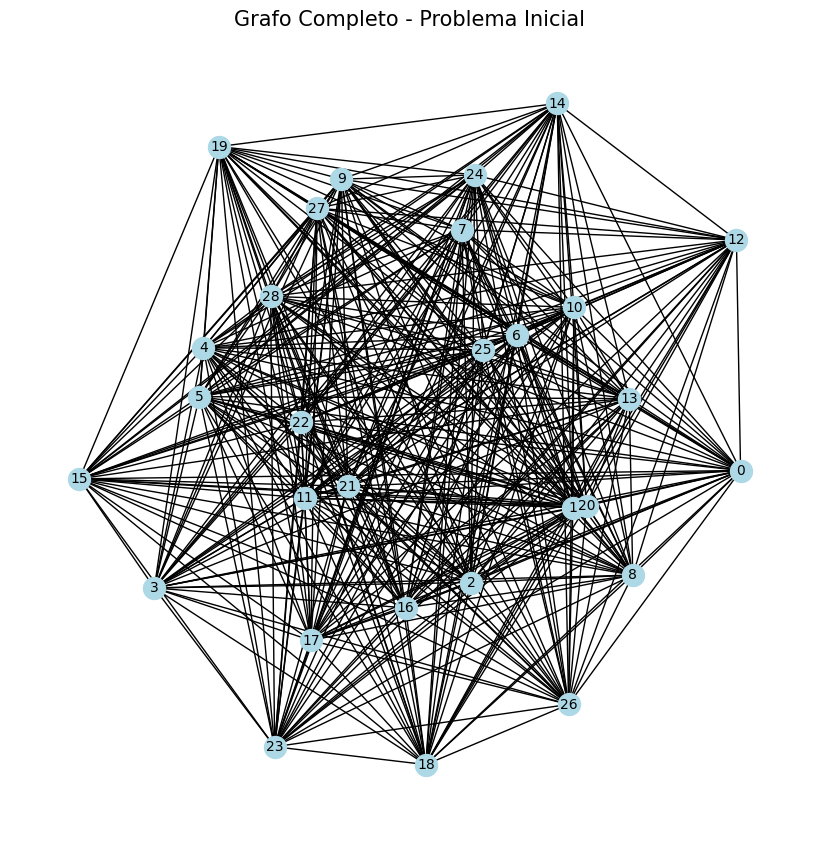


Iniciando o algoritmo...

----- Passo 1: Árvore Gerado Mínima -----
Arestas da AGM: [(20, 1, {'weight': 41.0}), (28, 2, {'weight': 60.0}), (9, 3, {'weight': 39.0}), (5, 4, {'weight': 51.0}), (27, 5, {'weight': 52.0}), (24, 6, {'weight': 72.0}), (26, 7, {'weight': 39.0}), (4, 8, {'weight': 42.0}), (19, 9, {'weight': 25.0}), (21, 10, {'weight': 63.0}), (5, 11, {'weight': 46.0}), (9, 12, {'weight': 51.0}), (17, 13, {'weight': 32.0}), (3, 14, {'weight': 34.0}), (26, 15, {'weight': 48.0}), (21, 16, {'weight': 47.0}), (14, 17, {'weight': 56.0}), (14, 18, {'weight': 49.0}), (1, 19, {'weight': 49.0}), (4, 20, {'weight': 50.0}), (13, 21, {'weight': 36.0}), (26, 22, {'weight': 74.0}), (0, 23, {'weight': 52.0}), (18, 24, {'weight': 52.0}), (4, 25, {'weight': 51.0}), (23, 26, {'weight': 38.0}), (0, 27, {'weight': 34.0}), (25, 28, {'weight': 36.0})]
Peso da AGM: 1319.0

----- Passo 2: Identificando os vértices de grau ímpar -----
Vértices de grau ímpar: [2, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 2

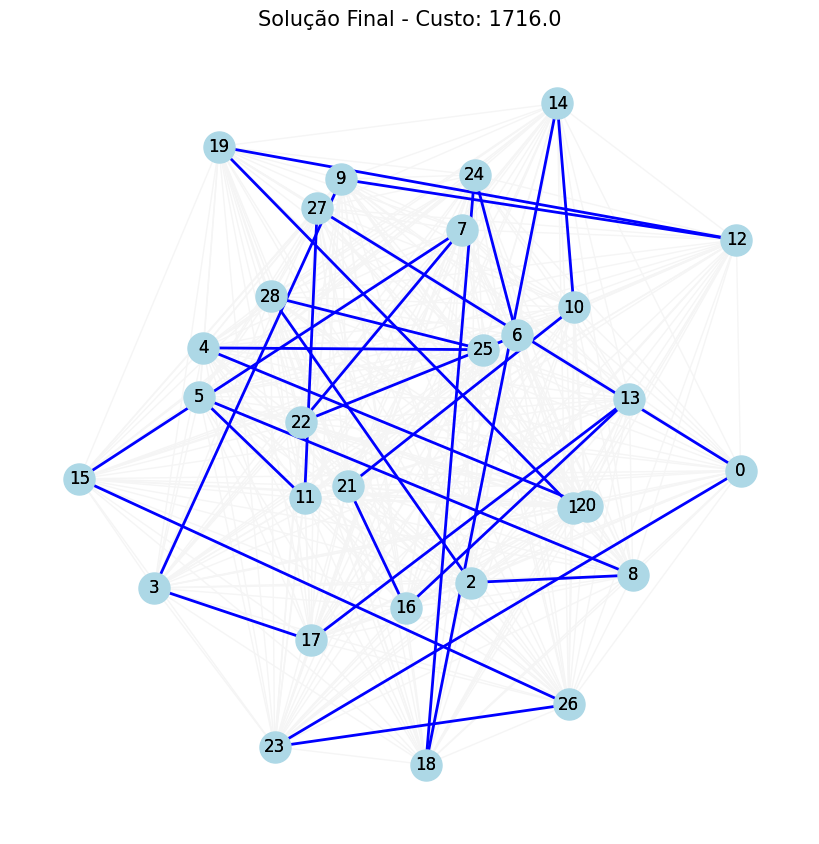

In [18]:
import matplotlib.pyplot as plt
try:
    # Ler a matriz do arquivo, o nome deve ser altera conforme o nome do arquivo
    arquivo = 'bayg29.tsp.txt'
    matriz, num_vertices = ler_matriz_do_arquivo(arquivo)


# --- VISUALIZAÇÃO - PASSO 1: Criar o grafo base e o layout ---

    # Criando um objeto de grafo networkx que representará o problema completo.
    G_completo = nx.Graph()
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if matriz[i][j] > 0:
                G_completo.add_edge(i, j, weight=matriz[i][j])

    # Gerando e salvando as posições (x, y) de cada vértice.
    # O spring_layout tenta posicionar os nós de uma forma esteticamente agradável.
    # Usar uma 'seed' (semente) garante que a aparência será exatamente a mesma toda vez que você rodar.
    print("Gerando layout do grafo...")
    posicoes = nx.spring_layout(G_completo, seed=42)

    # --- VISUALIZAÇÃO - PASSO 2: Mostrar o Grafo Antes do Algoritmo---

    print("Mostrando o grafo completo inicial...")
    plt.figure(figsize=(8, 8))
    nx.draw(
        G_completo,
        posicoes,
        with_labels=True,
        node_color='lightblue',
        node_size=250,
        font_size=10
    )
    plt.title("Grafo Completo - Problema Inicial", size=15)
    plt.show()

    print()
    print("Iniciando o algoritmo...")
    print()

    # Passo 1: Chamando a função de Prim
    arestas_da_agm, peso_da_agm = calcular_arvoregm(matriz, num_vertices)
    # Imprimir
    print("----- Passo 1: Árvore Gerado Mínima -----")
    print(f"Arestas da AGM: {arestas_da_agm}")
    print(f"Peso da AGM: {peso_da_agm}")
    print()

    # Passo 2: Identificando os vértices de grau ímpar
    vertices_impares = encontrar_vertices_grau_impar(arestas_da_agm, num_vertices)
    print("----- Passo 2: Identificando os vértices de grau ímpar -----")
    print(f"Vértices de grau ímpar: {vertices_impares}")
    print()

    # Passo 3: Emparelhamento de Custo mínimo
    arestas_do_emparelhamento, peso_do_emparelhamento = encontrar_emparelhamento_minimo(matriz, vertices_impares)
    print("----- Passo 3: Emparelhamento de Custo Mínimo -----")
    print(f"Arestas do Emparelhamento: {arestas_do_emparelhamento}")
    print(f"Peso do Emparelhamento: {peso_do_emparelhamento}")
    print()

    # Passo 4: Unindo as arestas da AGM e do Emparelhamento
    multigrafo_H_arestas = arestas_da_agm + arestas_do_emparelhamento
    print("----- Passo 4: Unindo as arestas da AGM e do Emparelhamento -----")
    print(f"Arestas em H: multigrafo_H_arestas")
    print(f"Total de arestas em H: {len(multigrafo_H_arestas)}")
    print()

     # Passo 5: Determinação de um ciclo euleriano em H
    ciclo_e = encontrar_ciclo_euleriano(multigrafo_H_arestas, num_vertices)
    print("----- Passo 5: Ciclo Euleriano -----")
    # print("Vértices no ciclo euleriano:", ciclo_e) # Pode ser muito longo para exibir
    print(f"O ciclo euleriano passa por {len(ciclo_e)} vértices (com repetições).")
    print()

    # Passo 6: Atalho (shortcutting) do ciclo euleriano
    caminho_final, custo_final = fazer_atalho_e_calcular_custo(ciclo_e, matriz)
    print("----- Passo 6: Solução Final (Ciclo Hamiltoniano) -----")
    print("Caminho Hamiltoniano Aproximado:", caminho_final)
    print(f"\nCusto Total da Solução: {custo_final}")

    print()
    print("Fim do algoritmo!")
    print()

 # --- VISUALIZAÇÃO - PASSO 3: Mostrar o Grafo Depois do Algoritmo ---

    # Criando um novo grafo vazio, apenas para a solução.
    G_solucao = nx.Graph()

    # Convertendo o caminho final [0, 5, 2, ..., 0] em uma lista de arestas [(0, 5), (5, 2), ...]
    arestas_solucao = []
    for i in range(len(caminho_final) - 1):
        arestas_solucao.append((caminho_final[i], caminho_final[i+1]))
    G_solucao.add_edges_from(arestas_solucao)

    print("\nMostrando o grafo com a solução final...")
    plt.figure(figsize=(8, 8))
    # Desenhando o grafo da solução, mas usando as MESMAS posições originais.
    # Estilizando as arestas da solução para que fiquem mais destacadas.
    nx.draw(
        G_completo, # Desenha todos os nós na posição correta
        posicoes,
        with_labels=True,
        node_color='lightblue',
        node_size=500,
        edge_color='whitesmoke' # Deixa as arestas originais quase invisíveis
    )
    nx.draw(
        G_solucao, # Desenha o grafo da solução por cima
        posicoes,
        with_labels=True,
        node_color='lightblue',
        node_size=250,
        edge_color='blue', # Arestas da solução em azul
        width=2.0 # Arestas da solução mais grossas
    )
    plt.title(f"Solução Final - Custo: {custo_final}", size=15)
    plt.show()


except FileNotFoundError:
    print(f"Erro: Arquivo {arquivo} não encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")
